<a href="https://colab.research.google.com/github/Lisarika-kanchumarthi/Time_Series_Modelling/blob/main/TimeSeriesModelling_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup & Library Imports**

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import boxcox
from scipy.fft import fft
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]


**Mounted Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Plotting the AMZN Dataset**

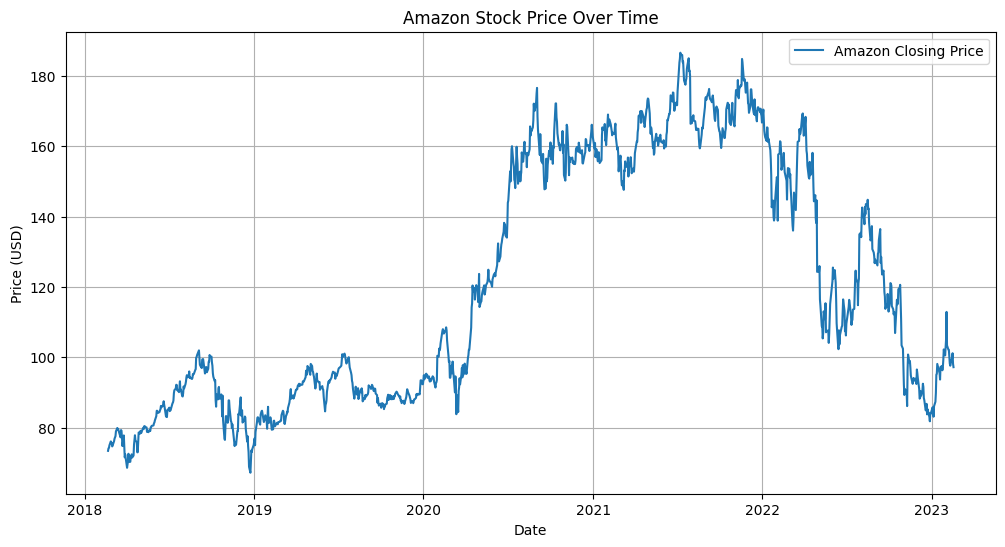

In [4]:
# Loading Amazon data
df_amzn = pd.read_csv('/content/drive/My Drive/TimeSeriesAssignment/AMZN.csv')

# Converting date column
df_amzn['Date'] = pd.to_datetime(df_amzn['Date'])
df_amzn.set_index('Date', inplace=True)
df_amzn.sort_index(inplace=True)

# Plotting the closing prices
plt.plot(df_amzn['Close'], label='Amazon Closing Price')
plt.title("Amazon Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.show()


**ADF Test – Checking for Stationarity**

In [5]:
# ADF test
result = adfuller(df_amzn['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")


ADF Statistic: -1.6578089913331728
p-value: 0.45297105465166737
Critical Value (1%): -3.4355588184378574
Critical Value (5%): -2.8638402312881497
Critical Value (10%): -2.5679946684494275


**First-order Differencing and Stationarity Check**

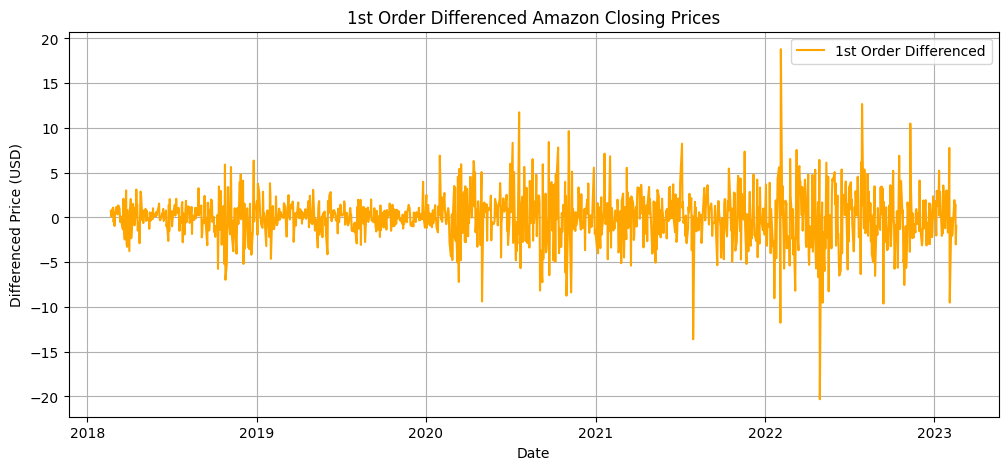

ADF Statistic (1st Differenced): -36.25077933242776
p-value (1st Differenced): 0.0
Critical Value (1%): -3.4355629707955395
Critical Value (5%): -2.863842063387667
Critical Value (10%): -2.567995644141416


In [6]:
# First-order differencing
amzn_diff1 = df_amzn['Close'].diff().dropna()

# Plotting the differenced series
plt.figure(figsize=(12, 5))
plt.plot(amzn_diff1, color='orange', label='1st Order Differenced')
plt.title("1st Order Differenced Amazon Closing Prices")
plt.xlabel("Date")
plt.ylabel("Differenced Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# ADF Test on first differenced series
result_diff1 = adfuller(amzn_diff1)
print("ADF Statistic (1st Differenced):", result_diff1[0])
print("p-value (1st Differenced):", result_diff1[1])
for key, value in result_diff1[4].items():
    print(f"Critical Value ({key}): {value}")


**Second-order Differencing**

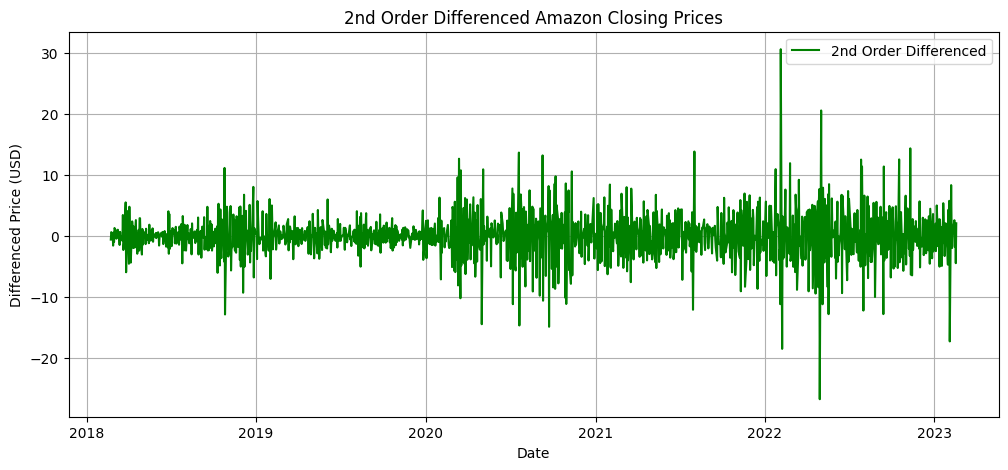

ADF Statistic (2nd Differenced): -12.67574011432976
p-value (2nd Differenced): 1.2169841133722277e-23
Critical Value (1%): -3.4356560275160835
Critical Value (5%): -2.8638831211270817
Critical Value (10%): -2.568017509711682


In [7]:
# Second-order differencing
amzn_diff2 = amzn_diff1.diff().dropna()

# Plotting the second-order differenced series
plt.figure(figsize=(12, 5))
plt.plot(amzn_diff2, color='green', label='2nd Order Differenced')
plt.title("2nd Order Differenced Amazon Closing Prices")
plt.xlabel("Date")
plt.ylabel("Differenced Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# ADF Test on second differenced series
result_diff2 = adfuller(amzn_diff2)
print("ADF Statistic (2nd Differenced):", result_diff2[0])
print("p-value (2nd Differenced):", result_diff2[1])
for key, value in result_diff2[4].items():
    print(f"Critical Value ({key}): {value}")


**ACF and PACF Plots (to identify p and q for ARIMA)**

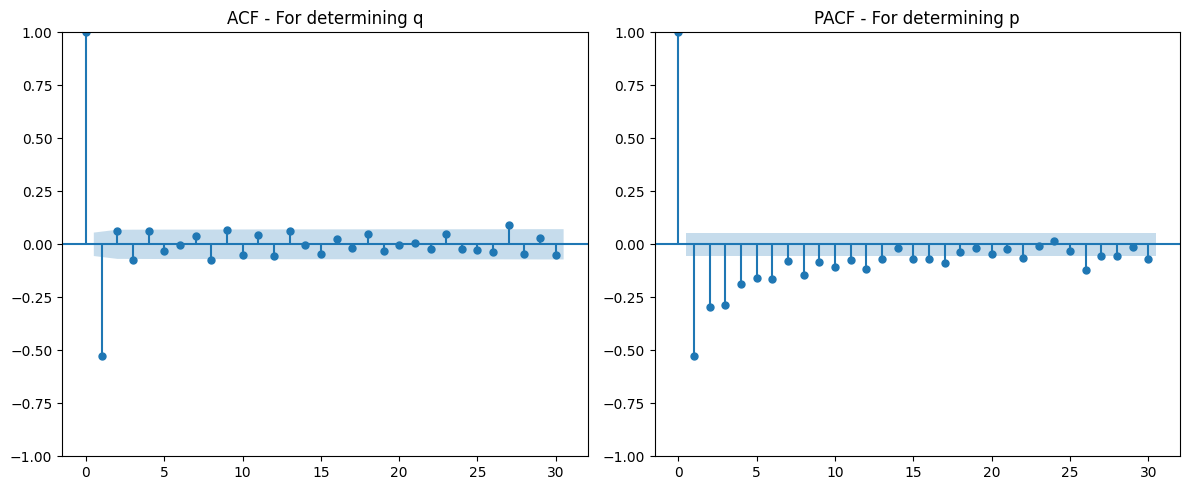

In [9]:
# ACF and PACF plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(amzn_diff2, lags=30, ax=plt.gca())
plt.title("ACF - For determining q")

plt.subplot(1, 2, 2)
plot_pacf(amzn_diff2, lags=30, ax=plt.gca())
plt.title("PACF - For determining p")

plt.tight_layout()
plt.show()


**ARIMA(1, 2, 1) Model for Amazon Stock**

In [11]:
# Fitting ARIMA(1,2,1)
model_amzn = ARIMA(df_amzn['Close'], order=(1, 2, 1))
model_fit_amzn = model_amzn.fit()

# Summary of the model
print(model_fit_amzn.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -3065.526
Date:                Fri, 11 Apr 2025   AIC                           6137.052
Time:                        08:55:38   BIC                           6152.462
Sample:                             0   HQIC                          6142.844
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0230      0.022     -1.063      0.288      -0.066       0.019
ma.L1         -0.9980      0.003   -372.630      0.000      -1.003      -0.993
sigma2         7.6538      0.173     44.140      0.0

**forecast the next 24 time steps**

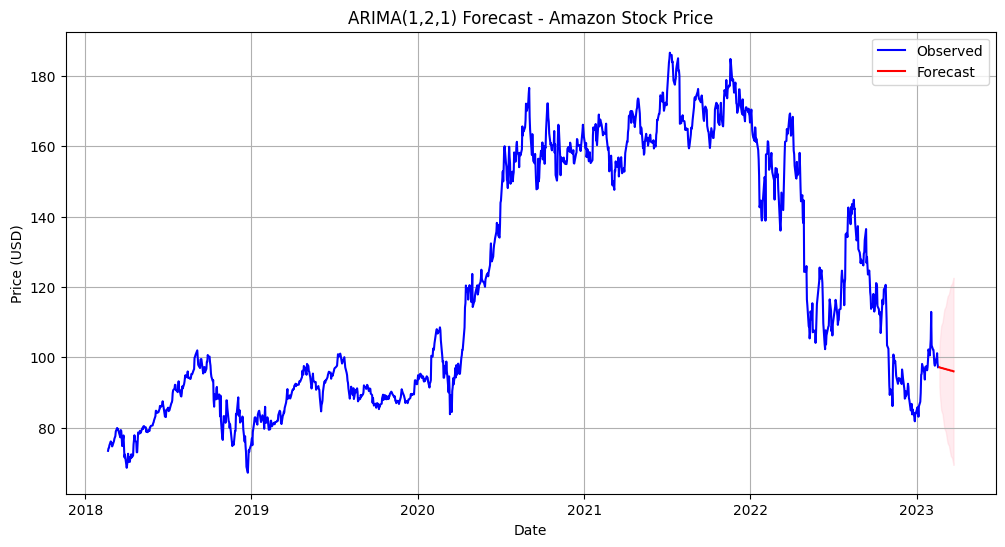

In [12]:
# Forecasting next 24 steps
forecast_amzn = model_fit_amzn.get_forecast(steps=24)
forecast_mean = forecast_amzn.predicted_mean
conf_int = forecast_amzn.conf_int()

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(df_amzn.index, df_amzn['Close'], label='Observed', color='blue')
forecast_index = pd.date_range(start=df_amzn.index[-1], periods=25, freq='B')[1:]  # Business days
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("ARIMA(1,2,1) Forecast - Amazon Stock Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


**Fourier Analysis**

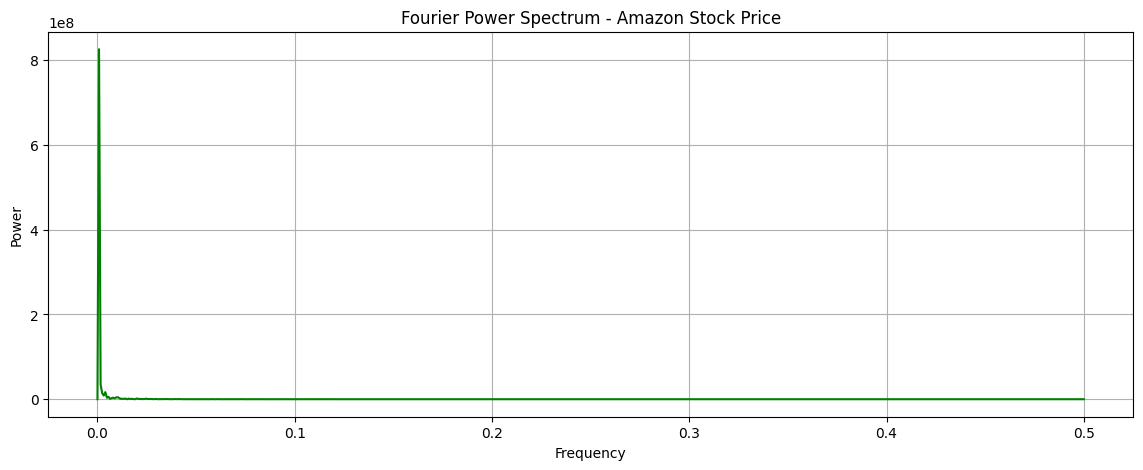

In [13]:
#  Extracting the closing price series
amzn_series = df_amzn['Close'] - np.mean(df_amzn['Close'])  # Detrend by removing mean

#  Applying FFT
amzn_fft = fft(amzn_series)
n_amzn = len(amzn_fft)
power_amzn = np.abs(amzn_fft[:n_amzn // 2])**2
freq_amzn = np.linspace(0, 0.5, n_amzn // 2)

#  Plotting the Fourier Power Spectrum
plt.figure(figsize=(14, 5))
plt.plot(freq_amzn, power_amzn, color='green')
plt.title('Fourier Power Spectrum - Amazon Stock Price')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.show()


**Installing Tensorflow**

In [14]:
!pip install tensorflow

**LSTM Forecasting**

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2598
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2490 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1810 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1513 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1378
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1170
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0821
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0686
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0486
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0385 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0423
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0392
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0369
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0378
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0395
Epoch 16/50
4/4 ━━━━━━━━━━━━━━

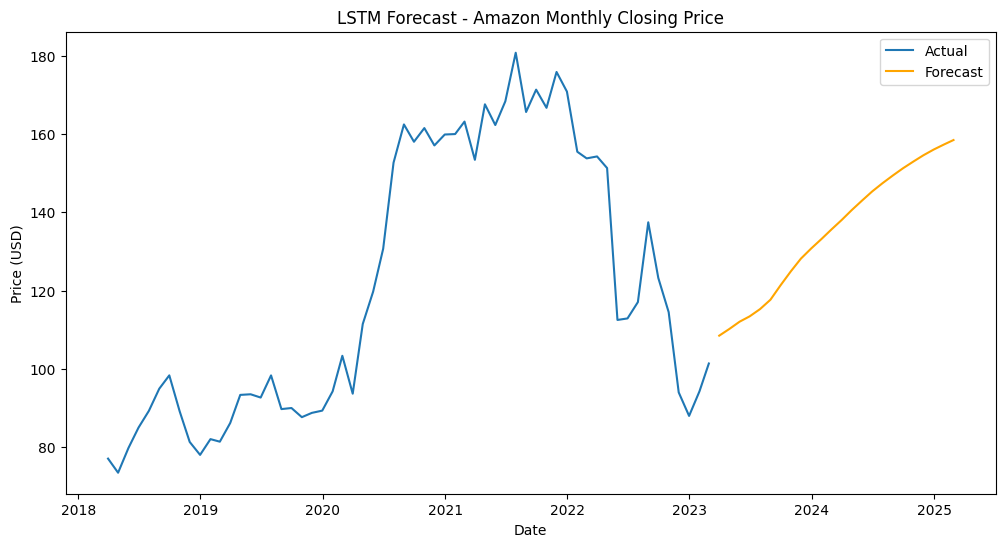

In [15]:
# Importing required libraries
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load and resample to monthly data
df_amzn_monthly = df_amzn['Close'].resample('M').mean()

# Normalizing the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_amzn_monthly.values.reshape(-1, 1))

# To create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # using past 12 months
X, y = create_sequences(scaled_data, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))  # reshape for LSTM input

# Define and training the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fitting the model
model.fit(X, y, epochs=50, batch_size=16, verbose=1)

# Forecasting the next 24 months
forecast_steps = 24
forecast_input = scaled_data[-seq_length:].reshape(1, seq_length, 1)
predictions = []

for _ in range(forecast_steps):
    pred = model.predict(forecast_input)[0][0]
    predictions.append(pred)
    forecast_input = np.append(forecast_input[:, 1:, :], [[[pred]]], axis=1)

# Inverse transform predictions
forecast_scaled = np.array(predictions).reshape(-1, 1)
forecast_prices = scaler.inverse_transform(forecast_scaled)

# Create future date range for forecast
forecast_index = pd.date_range(start=df_amzn_monthly.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='M')

# Plotting actual vs forecasted prices
plt.figure(figsize=(12, 6))
plt.plot(df_amzn_monthly[-60:], label='Actual')  # last 5 years of actual data
plt.plot(forecast_index, forecast_prices, label='Forecast', color='orange')
plt.title('LSTM Forecast - Amazon Monthly Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


**Evaluation Metrics for LSTM Forecast**

In [16]:
# Assuming 'df_amzn_monthly' contains the complete dataset
# Splitting the data into train and test sets
train_size = int(len(df_amzn_monthly) * 0.8)  # 80% for training
df_amzn_train = df_amzn_monthly[:train_size]
df_amzn_test = df_amzn_monthly[train_size:]

# Replacing with actual LSTM prediction and true values for Amazon
y_true_amzn = df_amzn_test.values.flatten()

# Adjusting the number of predictions to match the test set size
y_pred_amzn = np.array(predictions[:len(y_true_amzn)]).flatten()

mse_amzn = mean_squared_error(y_true_amzn, y_pred_amzn)
rmse_amzn = np.sqrt(mse_amzn)
mae_amzn = mean_absolute_error(y_true_amzn, y_pred_amzn)
mape_amzn = np.mean(np.abs((y_true_amzn - y_pred_amzn) / y_true_amzn)) * 100

# Printing results
print("Amazon LSTM Forecast Metrics:")
print(f"MSE: {mse_amzn:.4f}")
print(f"RMSE: {rmse_amzn:.4f}")
print(f"MAE: {mae_amzn:.4f}")
print(f"MAPE: {mape_amzn:.2f}%")

Amazon LSTM Forecast Metrics:
MSE: 14688.0382
RMSE: 121.1942
MAE: 119.1076
MAPE: 99.59%
